<a href="https://colab.research.google.com/github/markzaldivar/MAT422/blob/main/PrincipalComponentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Principal Component Analysis


## Singular Value Decomposition
As opposed to eigenvalue decomposition, singular value decompostion (SVD) is applicable to all matrices.

Let A be an $m\times n$ matrix with the dimension of $\text{col}(A) = r$. Then there exists an $m\times n$ matrix $\Sigma$, where
the diagonal entries in $D$ are the first $r$ singular values of $A$ $\sigma_1 \geq \sigma_2 \geq \cdots\geq \sigma_r\geq 0$, and there exist an $m\times m$ orthogonal matrix $U$ and an $n\times n$ orthogonal
matrix $V$ such that
$$A = U \sum V^T.$$


Any factorization $A = U \sum V^T$, with $U$ and $V$ orthogonal and $\sigma$, is called a singular value decomposition SVD of $A$. The matrices $U$ and $V$ are not unique, but the diagonal entries of $\sum$ are necessarily the singular values of $A$. The column of $U$ in such a decomposition are called left singular vectors of $A$, and the column of $V$ are called right singular vectors of $A$.

The singular values of $\sum$, arranged in decreasing order, represent the "strength" of each component of the matrix. Using this result, SVD can be used to approximating a matrix by retaining only the largest singular values. This results in a dimensionality reduction, which has various applications in image compression, principal component analysis, and more.

Below we explore the various applications of SVD in Python. We begin by using Python's built-in library functions to compute the SVD:



In [1]:

import numpy as np


def svd(matrix):
    # Using numpy's built-in svd function
    U, Sigma, VT = np.linalg.svd(matrix)

    # Sigma comes as a 1D array, so we need to convert it to a diagonal matrix
    Sigma_matrix = np.zeros((matrix.shape[0], matrix.shape[1]))
    np.fill_diagonal(Sigma_matrix, Sigma)

    return U, Sigma_matrix, VT


A = np.array([[3, 2], [2, 3]])


U, Sigma_matrix, VT = svd(A)

U, Sigma_matrix, VT


(array([[-0.70710678, -0.70710678],
        [-0.70710678,  0.70710678]]),
 array([[5., 0.],
        [0., 1.]]),
 array([[-0.70710678, -0.70710678],
        [-0.70710678,  0.70710678]]))

## Low-Rank Matrix Approximations
We expand on the idea of matrix approximations mentioned in the previous section.

Let $A \in \mathbb{R}^{n \times m}$ be a matrix with SVD
$$
A=\sum_{j=1}^{r} \sigma_{j} \mathbf{u}_{j} \mathbf{v}_{j}^{T}
$$
For $k<r$, truncate the sum at the $k$-th term
$$
A_{k}=\sum_{j=1}^{k} \sigma_{j} \mathbf{u}_{j} \mathbf{v}_{j}^{T}
$$
The rank of $A_{k}$ is exactly $k$. Indeed, by construction,
1. the vectors $\left\{\mathbf{u}_{j}: j=1, \ldots, k\right\}$ are orthonormal, and
2. since $\sigma_{j}>0$ for $j=1, \ldots, k$ and the vectors $\left\{\mathbf{v}_{j}: j=1, \ldots, k\right\}$ are orthonormal,$\left\{\mathbf{u}_{j}:\right.$ $j=1, \ldots, k\}$ spans the column space of $A_{k}$.

We apply low-rank matrix approximation to image compression, taking advantage of Python's skimage library. Our goal is to reduce the data size of the image while maintaining a reasonable visual quality.

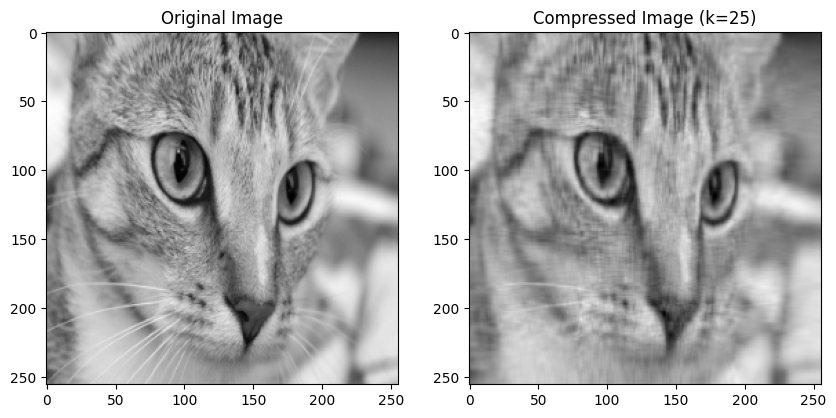

In [6]:

import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import resize


image = color.rgb2gray(data.cat())
image_resized = resize(image, (256, 256))  # Resize to make the image smaller for processing

# Compute SVD
U, Sigma, VT = np.linalg.svd(image_resized, full_matrices=False)

# Choose how many singular values to keep
k = 25  # Adjust this value to control compression

# Reconstruct the image using the top k singular values
U_k = U[:, :k]
Sigma_k = np.diag(Sigma[:k])
VT_k = VT[:k, :]
compressed_image = np.dot(U_k, np.dot(Sigma_k, VT_k))


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_resized, cmap='gray')

plt.subplot(1, 2, 2)
plt.title(f"Compressed Image (k={k})")
plt.imshow(compressed_image, cmap='gray')

plt.show()


## Principal Component Analysis
Principal component analysis (PCA) is commonly used for dimensionality reduction by projecting each data point onto only the first few principal components to obtain lower-dimensional data while preserving as much of the data’s variation as possible.

PCA requires the data matrix to be centered to ensure that the first principal component corresponds to the direction of maximum variance from the mean. Let $\left[\mathbf{X}_{1} \cdots \mathbf{X}_{N}\right]$ be a $p \times N$ matrix of observation. The sample mean $M$ of the observation vectors $\mathbf{X}_{1}, \ldots, \mathbf{X}_{n}$ is given by
$$
\mathbf{M}=\frac{1}{N}\left(\mathbf{X}_{1}+\cdots+\mathbf{X}_{N}\right)
$$
For $k=1, \ldots, N$, let
$$
\hat{\mathbf{X}}_{k}=\mathbf{X}_{k}-\mathbf{M}
$$
The columns of the $p \times N$ matrix
$$
B=\left[\hat{\mathbf{X}}_{1}, \hat{\mathbf{X}}_{2}, \cdots \hat{\mathbf{X}}_{N}\right]
$$
have a zero sample mean, and B is said to be in mean-deviation form. We now compute the covarience matrix:
$$
S=\frac{1}{N-1} B B^{T}
$$
The eigenvectors of $S$ represent the principal components and indicate in which directions the data varies most. We use eigenvalue decomposition to find the principal components:
$$
S=VΛV^T
$$
Where $V$ is the matrix of eigenvectors and $Λ$ is the diagonal matrix of eigenvalues. We reduce the dimensionality of the data by keeping only the top $k$ eigenvectors. We transform the data via the matrix $V_k$ consisting of the first $k$ eigenvectors.

Below we apply these concepts to the Iris dataset, which is loaded from the scikit-learn Python library. The Iris dataset contains 150 samples of iris flowers separated into 3 classes with four attributes for each flower: sepal length, sepal width, petal length, and petal width. We will use PCA to reduce the data to 2 dimensions and visualize the result in a scatterplot.

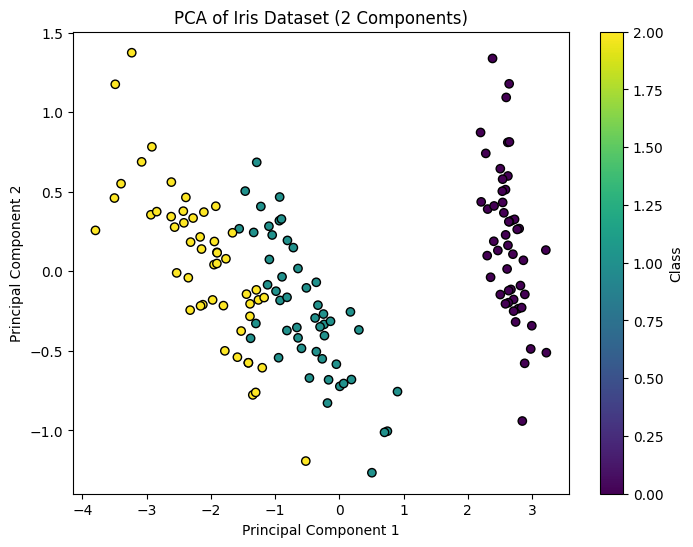

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris


def pca_with_eigen(X, k):
    # Center the data
    X_centered = X - np.mean(X, axis=0)

    # Compute the covariance matrix
    covariance_matrix = np.cov(X_centered, rowvar=False)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    #  Select the top k eigenvectors (principal components)
    V_k = sorted_eigenvectors[:, :k]

    # Transform the data to the lower-dimensional space
    X_reduced = np.dot(X_centered, V_k)

    return X_reduced, V_k, sorted_eigenvalues[:k]

# Load the Iris dataset
iris = load_iris()
X = iris.data  # 150 samples, 4 features
y = iris.target  # Class labels (0, 1, 2)

# Reduce the data to 2 principal components
X_reduced, principal_components, top_eigenvalues = pca_with_eigen(X, 2)

# Plot the data in the new 2D space
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Iris Dataset (2 Components)')
plt.colorbar(label = 'Class')
plt.show()
